In [1]:
import import_ipynb
import IntimeLibrary as il
import FlieLibrary as fl
import pandas as pd
import numpy as np

importing Jupyter notebook from IntimeLibrary.ipynb
importing Jupyter notebook from FlieLibrary.ipynb


In [4]:
fl.flight_from_cju.drop(['DelayRate','항공사','DelayRate'], axis=1, inplace=True)
fl.flight_from_cju = pd.get_dummies(fl.flight_from_cju, columns=["ORIGIN","DEST", "현황", "weekend"])
#fl.flight_to_gmp = pd.get_dummies(fl.flight_to_gmp, columns=["ORIGIN","DEST","항공사", "현황", "weekend"])
#fl.flight_from_gmp = pd.get_dummies(fl.flight_from_gmp, columns=["ORIGIN","DEST","항공사", "현황", "weekend"])
#fl.flight_to_cju = pd.get_dummies(fl.flight_to_cju, columns=["ORIGIN","DEST","항공사", "현황", "weekend"])

In [5]:
fl.flight_from_cju

,날짜,time,ORIGIN_제주공항,DEST_김포공항,현황_지연,현황_출발,현황_취소,현황_회항,weekend_FRI,weekend_Mon,weekend_SAT,weekend_SUN,weekend_THU,weekend_TUE,weekend_WED
0,20181001,6,1,1,0,1,0,0,0,1,0,0,0,0,0
1,20181001,6,1,1,0,1,0,0,0,1,0,0,0,0,0
2,20181001,7,1,1,0,1,0,0,0,1,0,0,0,0,0
3,20181001,7,1,1,0,1,0,0,0,1,0,0,0,0,0
4,20181001,7,1,1,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44092,20191001,21,1,1,1,0,0,0,0,0,0,0,0,1,0
44093,20191001,21,1,1,0,1,0,0,0,0,0,0,0,1,0
44094,20191001,21,1,1,1,0,0,0,0,0,0,0,0,1,0
44095,20191001,21,1,1,1,0,0,0,0,0,0,0,0,1,0


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(fl.flight_from_cju.drop("현황_출발", axis=1), fl.flight_from_cju["현황_출발"], test_size=0.2, random_state=42)

In [10]:
train_x.shape

(35277, 14)

In [11]:
test_x.shape

(8820, 14)

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

c:\users\kss09\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [13]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

1.0

In [14]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [15]:
roc_auc_score(test_y, probabilities[:, 1])

1.0

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[2230,    0],
       [   0, 6590]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

1.0

In [18]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

1.0

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

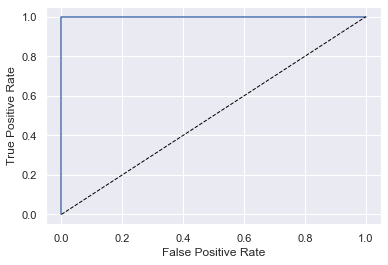

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [21]:
def predict_delay(departure_date_time, weekend, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    year = departure_date_time_parsed.year
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'날짜': year*10000+month*100+day,
              'time': hour,
              'ORIGIN_김포공항': 1 if origin == '김포' else 0,
              'ORIGIN_제주공항': 1 if origin == '제주' else 0,
              'DEST_김포공항': 1 if destination == '김포' else 0,
              'DEST_제주공항': 1 if destination == '제주' else 0,
              'weekend_FRI': 1 if destination == '금' else 0,
              'weekend_Mon': 1 if destination == '월' else 0,
              'weekend_SAT': 1 if destination == '토' else 0,
              'weekend_SUN': 1 if destination == '일' else 0,
              'weekend_THU': 1 if destination == '목' else 0,
              'weekend_TUE': 1 if destination == '화' else 0,
              'weekend_WED': 1 if destination == '수' else 0
            }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [22]:
predict_delay('02/03/2019 21:00:00', '토' , '제주공항', '김포공항')

ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 13 